In [ ]:
# Mount Google drive for save and load LSTM models if you're using colab 
# , and if your files are saved in Google drive
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  from google.colab import drive
  drive.mount('/content/drive')
    
else:
  print('Not running on Colab')

Running on Colab
Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import joblib
import time

In [ ]:
# For LSTM model
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from keras.models import load_model

In [ ]:
import time
from scipy.optimize import minimize

In [ ]:
# Load model files (LSTM and MinMaxScaler)
if 'google.colab' in str(get_ipython()):
  print('Running on Colab')
  model = load_model('/content/drive/MyDrive/LSTM_MPC/FOPDT/model.h5')
  s1 = joblib.load('/content/drive/MyDrive/LSTM_MPC/FOPDT/s1.sav')
  s2 = joblib.load('/content/drive/MyDrive/LSTM_MPC/FOPDT/s2.sav')
  
else:
  print('Not running on Colab')
  model = load_model('model.h5')
  s1 = joblib.load('s1.sav')
  s2 = joblib.load('s2.sav')

Running on Colab


In [ ]:
def MPCobj(u_hat, y_hat, SP_hat, u, y, SP, window, P, M):
  u_hat_P = np.ones(P-M) * u_hat[-1] # future u values after the control horizon
  u_all = np.concatenate((u, u_hat, u_hat_P),axis=None)
  y_all = np.append(y, y_hat)

  X = np.transpose([u_all,y_all]) 
  Y = np.transpose([y_all])
  SP_trans = np.transpose([SP_hat])

  Xs = s1.transform(X)
  Ys = s2.transform(Y)
  SPs = s2.transform(SP_trans)

  # Appending the window (past) and Prediction (future) arrays
  Xsq = Xs.copy()
  Ysq = Ys.copy()
  # SPsq = np.reshape(SP_pred, (P,Ys.shape[1]))
  for i in range(window,len(Xsq)):
      Xin = Xsq[i-window:i].reshape((1, window, np.shape(Xsq)[1]))
      # LSTM prediction
      Xsq[i][(Xs.shape[1] - Ys.shape[1]):] = model(Xin) 
      # (Xs.shape[1]-Ys.shape[1]) indicates the index of the 
      # first 'system' output variable in the 'LSTM' input array
      Ysq[i] = Xsq[i][(Xs.shape[1] - Ys.shape[1]):]
  
  Ytu = s2.inverse_transform(Ysq)
  Xtu = s1.inverse_transform(Xsq)

  u_hat0 = np.append(u[-1], u_hat)
  pred["y_hat"] = np.reshape(Ytu[window:], (1,P))[0]
  pred["u_hat"] = np.reshape(Xtu[window:,0], (1,P))[0]

  Obj = 10*np.sum((pred["y_hat"] - SP_hat)**2) + np.sum(((u_hat0[1:] - u_hat0[0:-1])**2))

  return Obj

In [ ]:
window = 5 # Window (for past values)
P = 10 # Prediction Horizon (for CV)
M = 4 # Control Horizon (for MV)

In [ ]:
# Values at time=k- (past)
u = np.ones(window) * 0
y = np.ones(window) * 0
SP = np.ones(window) * 1 # Setpoint

# Initial Values at time=k+ (in prediction horizon)
t_hat = np.linspace(0,P-1,P)
u_hat = np.ones(M) * u[-1]
y_hat = np.ones_like(t_hat) * y[-1]
SP_hat = np.ones_like(t_hat) * SP[-1]

pred = {
    "y_hat": np.ones_like(t_hat) * y[-1],
    "u_hat": np.ones_like(t_hat) * u[-1]
    }

In [ ]:
t0 = time.time()
solution = minimize(MPCobj, u_hat, method='SLSQP',args=(y_hat, SP_hat, u, y, SP, window, P, M),options={'eps': 1e-06, 'ftol': 1e-01})
t1 = time.time()
print('Runtime: %.2f s' %(t1-t0))

Runtime: 9.65 s


In [ ]:
print(solution)

     fun: 13.093254519574558
     jac: array([ 0.11553717,  0.06042247, -0.06523067, -0.01603326])
 message: 'Optimization terminated successfully.'
    nfev: 37
     nit: 5
    njev: 5
  status: 0
 success: True
       x: array([1.46080826, 1.37774953, 1.2020566 , 1.05430738])


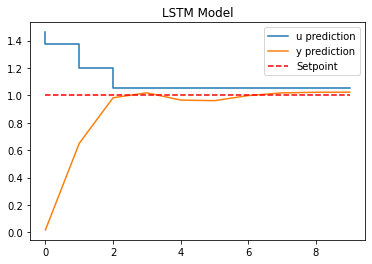

In [ ]:
plt.figure()
plt.title("LSTM Model")
plt.step(t_hat,pred["u_hat"], label='u prediction')
plt.plot(t_hat,pred["y_hat"], label='y prediction')
plt.plot(t_hat,SP_hat, 'r--', label='Setpoint')
plt.legend()
plt.show()